# Analyse Météo 2019-2022

## 1. Récupération de la data

La data traité est fournie par le National Oceanic and Atmospheric Administration (NOAA) qui contient des mesures météorologiques fournies par des stations partout dans le monde depuis 1901. Cette data permet de faire une analyse sur les changements climatiques.

La data est récupérée soit par :
- ftp://ftp.ncdc.noaa.gov/pub/data/noaa
- https://www.ncei.noaa.gov/data/global-hourly/access/

Les données présentent plus de 100GB de data compressée.

Fichiers utiles :
- Le fichier isd-history.csv contient la liste de toutes les stations et leurs infos (Pays, latitude, etc...)
- Le fichier isd-format-document.pdf permet aussi d'avoir des détails importants pour interpréter la data

## 2 . Recommendations Hardware 

Les données météorologiques comporte plus de 100 GB. Une machine rapide avec beaucoup de RAM and du stockage rapide est recommandé.
Dans notre analyse nous avons choisi une plage de 2019 - 2020. 

## 3. Notebook steup

## Les imports

In [1]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

## Session Spark

In [3]:
spark = SparkSession \
        .builder \
        .getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
spark.sparkContext.setLogLevel("ERROR")
warnings.filterwarnings('ignore')

In [4]:
spark

## PATHS

### A. Lire de la data depuis le HDFS

In [5]:
weather_data = "hdfs://namenode:9000/user/root/data"
results_basedir = "hdfs://namenode:9000/user/root/results"

## Récupérer les stations

In [6]:
weather_stations = spark.read \
    .option("header", True) \
    .csv("./isd-history.csv")

- USAF et WBAN Contiennent les IDs des stations 
- CTRY contient le code code FIPS 
- BEGIN et END c'est la durée de vie de chaque station
- LAT and LON sont les coordonnées géologiques

In [7]:
weather_stations = weather_stations \
    .withColumn("station_id",f.concat(f.col("usaf"),
    f.col("wban"))) \
    .withColumnRenamed("STATION NAME", "STATION_NAME") \
    .withColumnRenamed("ELEV(M)", "ELEVATION")

In [141]:
weather_stations

USAF,WBAN,STATION_NAME,CTRY,STATE,ICAO,LAT,LON,ELEVATION,BEGIN,END,station_id
007018,99999,WXPOD 7018,null,null,null,+00.000,+000.000,+7018.0,20110309,20130730,00701899999
007026,99999,WXPOD 7026,AF,null,null,+00.000,+000.000,+7026.0,20120713,20170822,00702699999
007070,99999,WXPOD 7070,AF,null,null,+00.000,+000.000,+7070.0,20140923,20150926,00707099999
008260,99999,WXPOD8270,null,null,null,+00.000,+000.000,+0000.0,20050101,20120731,00826099999
008268,99999,WXPOD8278,AF,null,null,+32.950,+065.567,+1156.7,20100519,20120323,00826899999
008307,99999,WXPOD 8318,AF,null,null,+00.000,+000.000,+8318.0,20100421,20100421,00830799999
008411,99999,XM20,null,null,null,null,null,null,20160217,20160217,00841199999
008414,99999,XM18,null,null,null,null,null,null,20160216,20160217,00841499999
008415,99999,XM21,null,null,null,null,null,null,20160217,20200314,00841599999
008418,99999,XM24,null,null,null,null,null,null,20160217,20160217,00841899999


In [142]:
weather_stations.count()

29610

## Récupérer les données des mesures

In [8]:
raw_weather = spark.read.text(weather_data)

### Extraction des mesures de temperature et vitesse de vent

In [144]:
raw_weather.select(
        f.substring(raw_weather["value"],5,6).alias("usaf"),
        f.substring(raw_weather["value"],11,5).alias("wban"),
        f.to_timestamp(f.substring(raw_weather["value"],16,12), "yyyyMMddHHmm").alias("ts"),
        f.substring(raw_weather["value"],42,5).alias("report_type"),
        f.substring(raw_weather["value"],61,3).alias("wind_direction"),
        f.substring(raw_weather["value"],64,1).alias("wind_direction_qual"),
        f.substring(raw_weather["value"],65,1).alias("wind_observation"),
        (f.substring(raw_weather["value"],66,4).cast("float") / 10.0).alias("wind_speed"),
        f.substring(raw_weather["value"],70,1).alias("wind_speed_qual"),
        (f.substring(raw_weather["value"],88,5).cast("float") / 10.0).alias("air_temperature"),
        f.substring(raw_weather["value"],93,1).alias("air_temperature_qual")
    ) \
    .withColumn("date", f.to_date(f.col("ts")))

usaf,wban,ts,report_type,wind_direction,wind_direction_qual,wind_observation,wind_speed,wind_speed_qual,air_temperature,air_temperature_qual,date
999999,73803,2020-01-01 00:00:00,CRN05,296,1,H,1.2,1,7.6,1,2020-01-01
999999,73803,2020-01-01 00:05:00,CRN05,295,1,H,1.2,1,7.6,1,2020-01-01
999999,73803,2020-01-01 00:10:00,CRN05,295,1,H,1.1,1,7.2,1,2020-01-01
999999,73803,2020-01-01 00:15:00,CRN05,286,1,H,1.0,1,6.0,1,2020-01-01
999999,73803,2020-01-01 00:20:00,CRN05,266,1,H,0.6,1,5.4,1,2020-01-01
999999,73803,2020-01-01 00:25:00,CRN05,208,1,H,0.2,1,5.5,1,2020-01-01
999999,73803,2020-01-01 00:30:00,CRN05,999,9,9,0.0,1,5.5,1,2020-01-01
999999,73803,2020-01-01 00:35:00,CRN05,999,9,9,0.0,1,5.2,1,2020-01-01
999999,73803,2020-01-01 00:40:00,CRN05,999,9,9,0.0,1,5.1,1,2020-01-01
999999,73803,2020-01-01 00:45:00,CRN05,168,1,H,0.1,1,5.3,1,2020-01-01


### Extraction des mesures de précipitation

- AA1 - AA4 sont des indicateurs qui se répètent :
- LIQUID-PRECIPITATION quantité
- LIQUID-PRECIPITATION profondeur
- LIQUID-PRECIPITATION code de condition
- LIQUID-PRECIPITATION code de qualité

In [9]:
def extract_precipitation(df, index, start_position):
    column = f"AA{index}"
    return df.withColumn(column, f.when(f.substring(raw_weather["value"], start_position, 3) == f.lit(f"AA{index}"),f.substring(raw_weather["value"], start_position+3, 8) )) \
        .withColumn(f"precipitation_hours_{index}", f.substring(f.col(column), 1, 2).cast("INT")) \
        .withColumn(f"precipitation_depth_{index}", f.substring(f.col(column), 3, 4).cast("FLOAT")) \
        .withColumn(f"precipitation_cond_{index}", f.substring(f.col(column), 7, 1)) \
        .withColumn(f"precipitation_qual_{index}", f.substring(f.col(column), 8, 1)) \
        .drop(column)

df = extract_precipitation(raw_weather, 1, 109)
df = extract_precipitation(df, 2, 120)
df = extract_precipitation(df, 3, 131)
df = extract_precipitation(df, 4, 142)

#clean df
#df.filter("AA1 IS NOT NULL AND precipitation_cond_1 == '9' AND precipitation_depth_1 > 0") \
#    .limit(10).toPandas()
#df


### Extraction de toutes les mesures

In [10]:
def extract_weather_measurements(raw_weather):
    df = raw_weather.select(
        raw_weather["value"],
        f.substring(raw_weather["value"],5,6).alias("usaf"),
        f.substring(raw_weather["value"],11,5).alias("wban"),
        f.to_timestamp(f.substring(raw_weather["value"],16,12), "yyyyMMddHHmm").alias("ts"),
        f.to_date(f.substring(raw_weather["value"],16,8), "yyyyMMdd").alias("date"),
        f.substring(raw_weather["value"],42,5).alias("report_type"),
        f.substring(raw_weather["value"],61,3).alias("wind_direction"),
        f.substring(raw_weather["value"],64,1).alias("wind_direction_qual"),
        f.substring(raw_weather["value"],65,1).alias("wind_observation"),
        (f.substring(raw_weather["value"],66,4).cast("float") / 10.0).alias("wind_speed"),
        f.substring(raw_weather["value"],70,1).alias("wind_speed_qual"),
        (f.substring(raw_weather["value"],88,5).cast("float") / 10.0).alias("air_temperature"),
        f.substring(raw_weather["value"],93,1).alias("air_temperature_qual"),
        f.when(f.instr(raw_weather["value"],"AA1") == 109,f.substring(raw_weather["value"], 109+3, 8)).alias("AA1")
    )

    df = extract_precipitation(df, 1, 109)
    df = extract_precipitation(df, 2, 120)
    df = extract_precipitation(df, 3, 131)
    df = extract_precipitation(df, 4, 142)

    return df.drop("value")

In [11]:
weather = extract_weather_measurements(raw_weather)

In [148]:
weather.orderBy("usaf","wban","ts").limit(10).toPandas()

,usaf,wban,ts,date,report_type,wind_direction,wind_direction_qual,wind_observation,wind_speed,wind_speed_qual,...,precipitation_cond_2,precipitation_qual_2,precipitation_hours_3,precipitation_depth_3,precipitation_cond_3,precipitation_qual_3,precipitation_hours_4,precipitation_depth_4,precipitation_cond_4,precipitation_qual_4
0,008415,99999,2020-03-13 04:54:00,2020-03-13,FM-15,020,1,N,8.2,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
1,008415,99999,2020-03-13 05:54:00,2020-03-13,FM-15,020,1,N,8.8,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
2,008415,99999,2020-03-13 08:54:00,2020-03-13,FM-15,020,1,N,8.8,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
3,008415,99999,2020-03-13 10:54:00,2020-03-13,FM-15,040,1,N,6.7,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
4,008415,99999,2020-03-13 11:54:00,2020-03-13,FM-15,050,1,N,6.2,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
5,008415,99999,2020-03-13 12:54:00,2020-03-13,FM-15,040,1,N,6.2,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
6,008415,99999,2020-03-14 03:54:00,2020-03-14,FM-15,020,1,N,4.6,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
7,008415,99999,2020-03-14 05:54:00,2020-03-14,FM-15,020,1,N,7.2,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
8,008415,99999,2020-03-14 06:54:00,2020-03-14,FM-15,020,1,N,7.2,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
9,008415,99999,2020-03-14 07:54:00,2020-03-14,FM-15,020,1,N,7.2,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None


In [108]:
### Nombre de lignes 
#weather.count()

44106473

## Les codes de conditions de mesure
Le fichier isd-format-document.pdf permet aussi d'avoir des détails importants pour interpréter la data. Afin d'avoir que des données valides nous allons utiliser les codes de condtions fournis dans le fichier

### Les codes de conditions de mesure de température

- 0 = Passed gross limits check
- 1 = Passed all quality control checks
- 2 = Suspect
- 3 = Erroneous
- 4 = Passed gross limits check, data originate from an NCEI data source
- 5 = Passed all quality control checks, data originate from an NCEI data source
- 6 = Suspect, data originate from an NCEI data source
- 7 = Erroneous, data originate from an NCEI data source
- 9 = Passed gross limits check if element is present
- A = Data value flagged as suspect, but accepted as a good value
- C = Temperature and dew point received from Automated Weather Observing System (AWOS) are reported in whole degrees Celsius. Automated QC flags these values, but they are accepted as valid.
- I = Data value not originally in data, but inserted by validator
- M = Manual changes made to value based on information provided by NWS or FAA
- P = Data value not originally flagged as suspect, but replaced by validator
- R = Data value replaced with value computed by NCEI software
- U = Data value replaced with edited value

Nous allons garder que les résultats avec des les codes valides => `1`, `5`, `R`

### Wind Condition Codes

- 0 = Passed gross limits check
- 1 = Passed all quality control checks
- 2 = Suspect
- 3 = Erroneous
- 4 = Passed gross limits check, data originate from an NCEI data source
- 5 = Passed all quality control checks, data originate from an NCEI data source
- 6 = Suspect, data originate from an NCEI data source
- 7 = Erroneous, data originate from an NCEI data source
- 9 = Passed gross limits check if element is present

Nous allons garder que les résultats avec des les codes valides => `1`, `5`

### Precipitation Condition Codes

* 1 = Measurement impossible or inaccurate
* 2 = Trace
* 3 = Begin accumulated period (precipitation amount missing until end of accumulated period)
* 4 = End accumulated period
* 5 = Begin deleted period (precipitation amount missing due to data problem)
* 6 = End deleted period
* 7 = Begin missing period
* 8 = End missing period
* E = Estimated data value (eg, from nearby station)
* I = Incomplete precipitation amount, excludes one or more missing reports, such as one or more 15-minute reports not included in the 1-hour precipitation total
* J = Incomplete precipitation amount, excludes one or more erroneous reports, such as one or more 1-hour precipitation amounts excluded from the 24-hour total
* 9 = Missing

Nous allons garder que les résultats avec des les codes valides => `2`, `4`, `E`

### Extraction des données valides

In [12]:
valid_weather = weather \
    .withColumn("date", f.to_date(weather["ts"])) \
    .withColumn("hour", f.hour(weather["ts"])) \
    .withColumn("valid_wind_speed", f.when(weather["wind_speed_qual"].isin('1','5'), weather["wind_speed"])) \
    .withColumn("valid_air_temperature", f.when(weather["air_temperature_qual"].isin('1','5','R'), weather["air_temperature"])) \
    .withColumn("valid_precipitation", f.coalesce(
                f.when(weather["precipitation_qual_1"].isin('1','5','R') & weather["precipitation_cond_1"].isin('2','4','E'), weather["precipitation_depth_1"]),
                f.when(weather["precipitation_qual_2"].isin('1','5','R') & weather["precipitation_cond_2"].isin('2','4','E'), weather["precipitation_depth_2"]),
                f.when(weather["precipitation_qual_3"].isin('1','5','R') & weather["precipitation_cond_3"].isin('2','4','E'), weather["precipitation_depth_3"]),
                f.when(weather["precipitation_qual_4"].isin('1','5','R') & weather["precipitation_cond_4"].isin('2','4','E'), weather["precipitation_depth_4"])
            ))

In [13]:
valid_weather.where("valid_precipitation IS NOT NULL").limit(10).toPandas()
valid_weather

usaf,wban,ts,date,report_type,wind_direction,wind_direction_qual,wind_observation,wind_speed,wind_speed_qual,air_temperature,air_temperature_qual,precipitation_hours_1,precipitation_depth_1,precipitation_cond_1,precipitation_qual_1,precipitation_hours_2,precipitation_depth_2,precipitation_cond_2,precipitation_qual_2,precipitation_hours_3,precipitation_depth_3,precipitation_cond_3,precipitation_qual_3,precipitation_hours_4,precipitation_depth_4,precipitation_cond_4,precipitation_qual_4,hour,valid_wind_speed,valid_air_temperature,valid_precipitation
010100,99999,2019-01-01 00:00:00,2019-01-01,FM-12,050,1,N,8.0,1,1.4,1,6,0.0,9,1,null,null,null,null,null,null,null,null,null,null,null,null,0,8.0,1.4,null
010100,99999,2019-01-01 00:20:00,2019-01-01,FM-15,060,1,N,9.3,1,2.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,9.3,2.0,null
010100,99999,2019-01-01 00:50:00,2019-01-01,FM-15,060,1,N,8.2,1,2.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,8.2,2.0,null
010100,99999,2019-01-01 01:00:00,2019-01-01,FM-12,050,1,N,8.2,1,1.7,1,1,9999.0,9,9,null,null,null,null,null,null,null,null,null,null,null,null,1,8.2,1.7,null
010100,99999,2019-01-01 01:20:00,2019-01-01,FM-15,060,1,N,8.2,1,2.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,8.2,2.0,null
010100,99999,2019-01-01 01:50:00,2019-01-01,FM-15,050,1,N,8.2,1,2.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,8.2,2.0,null
010100,99999,2019-01-01 02:00:00,2019-01-01,FM-12,040,1,N,9.0,1,1.8,1,1,0.0,9,1,null,null,null,null,null,null,null,null,null,null,null,null,2,9.0,1.8,null
010100,99999,2019-01-01 02:20:00,2019-01-01,FM-15,050,1,N,9.3,1,2.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2,9.3,2.0,null
010100,99999,2019-01-01 02:50:00,2019-01-01,FM-15,040,1,N,10.3,1,2.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2,10.3,2.0,null
010100,99999,2019-01-01 03:00:00,2019-01-01,FM-12,040,1,N,11.0,1,1.7,1,1,0.0,9,1,null,null,null,null,null,null,null,null,null,null,null,null,3,11.0,1.7,null


### Calculs horaire

In [14]:
hourly_weather = valid_weather \
    .withColumn("date", f.to_date(valid_weather["ts"])) \
    .withColumn("hour", f.hour(valid_weather["ts"])) \
    .groupBy("usaf", "wban", "date", "hour") \
    .agg( 
        f.avg(valid_weather["valid_wind_speed"]).alias("wind_speed"),
        f.avg(valid_weather["valid_air_temperature"]).alias("temperature"),
        f.sum(valid_weather["valid_precipitation"]).alias("precipitation")
    )

In [15]:
hourly_weather

usaf,wban,date,hour,wind_speed,temperature,precipitation
010100,99999,2019-01-07,21,14.266666666666666,2.6333333333333333,null
010100,99999,2019-01-11,15,14.066666666666668,1.3333333333333333,null
010100,99999,2019-01-11,21,11.633333333333335,0.0,null
010100,99999,2019-01-20,0,4.733333333333333,-5.966666666666666,null
010100,99999,2019-01-29,9,7.8,-4.1000000000000005,null
010100,99999,2019-02-11,12,9.466666666666667,1.9000000000000001,null
010100,99999,2019-02-22,1,7.366666666666666,-2.1333333333333333,null
010100,99999,2019-02-26,12,5.133333333333333,1.1666666666666667,null
010100,99999,2019-03-11,19,8.133333333333333,-1.9000000000000001,null
010100,99999,2019-03-16,23,6.333333333333333,-2.5,null


### Calculs journalières

In [18]:
daily_weather = hourly_weather.withColumn("station_id",f.concat(f.col("usaf"),
    f.col("wban"))) \
    .groupBy("station_id", "date")\
    .agg(
        f.min("temperature").alias("min_temperature"),
        f.max("temperature").alias("max_temperature"),
        f.avg("temperature").alias("avg_temperature"),
        f.min("wind_speed").alias("min_wind_speed"),
        f.max("wind_speed").alias("max_wind_speed"),
        f.avg("wind_speed").alias("avg_wind_speed"),
        f.sum("precipitation").alias("precipitation"),
    )

In [19]:
daily_weather

station_id,date,min_temperature,max_temperature,avg_temperature,min_wind_speed,max_wind_speed,avg_wind_speed,precipitation
01010099999,2019-12-28,0.9,8.0,4.127777777777777,7.466666666666666,16.333333333333332,11.572222222222223,null
01007099999,2019-07-30,6.0,8.7,7.629166666666666,1.0,4.0,1.9363636363636365,null
01008099999,2019-07-25,5.55,10.3,8.478472222222221,1.0,9.0,5.633333333333333,null
01008099999,2021-12-24,-15.299999999999999,-11.0,-13.1,3.5,10.3,6.782638888888887,null
01001099999,2020-01-31,-1.4,1.7,-0.00454545454545...,1.0,16.0,9.931818181818182,null
01001099999,2021-07-02,1.5,5.2,2.968421052631579,0.7,4.4,2.3684210526315788,null
01008099999,2021-03-04,-18.133333333333333,-14.0,-16.212500000000002,3.1,7.5,6.1819444444444445,null
01007099999,2019-06-15,1.0,5.1,2.879166666666667,1.0,11.0,6.643478260869566,null
01001099999,2021-12-18,-5.5,0.0,-3.1199999999999997,4.4,14.5,10.506666666666664,null
01008099999,2020-12-29,-2.0,1.0,0.22083333333333335,2.6,10.233333333333333,6.67013888888889,null


In [20]:
weather_stations.limit(10).toPandas()

,USAF,WBAN,STATION_NAME,CTRY,STATE,ICAO,LAT,LON,ELEVATION,BEGIN,END,station_id
0,007018,99999,WXPOD 7018,None,None,None,+00.000,+000.000,+7018.0,20110309,20130730,00701899999
1,007026,99999,WXPOD 7026,AF,None,None,+00.000,+000.000,+7026.0,20120713,20170822,00702699999
2,007070,99999,WXPOD 7070,AF,None,None,+00.000,+000.000,+7070.0,20140923,20150926,00707099999
3,008260,99999,WXPOD8270,None,None,None,+00.000,+000.000,+0000.0,20050101,20120731,00826099999
4,008268,99999,WXPOD8278,AF,None,None,+32.950,+065.567,+1156.7,20100519,20120323,00826899999
5,008307,99999,WXPOD 8318,AF,None,None,+00.000,+000.000,+8318.0,20100421,20100421,00830799999
6,008411,99999,XM20,None,None,None,None,None,None,20160217,20160217,00841199999
7,008414,99999,XM18,None,None,None,None,None,None,20160216,20160217,00841499999
8,008415,99999,XM21,None,None,None,None,None,None,20160217,20200314,00841599999
9,008418,99999,XM24,None,None,None,None,None,None,20160217,20160217,00841899999


### Fusionner les données des stations et les mesures 

In [22]:
joined_data = daily_weather.join(weather_stations, ["station_id"], "left")
joined_data

station_id,date,min_temperature,max_temperature,avg_temperature,min_wind_speed,max_wind_speed,avg_wind_speed,precipitation,USAF,WBAN,STATION_NAME,CTRY,STATE,ICAO,LAT,LON,ELEVATION,BEGIN,END
01010099999,2019-12-28,0.9,8.0,4.127777777777777,7.466666666666666,16.333333333333332,11.572222222222223,null,010100,99999,ANDOYA,NO,null,ENAN,+69.293,+016.144,+0013.1,19310103,20220501
01007099999,2019-07-30,6.0,8.7,7.629166666666666,1.0,4.0,1.9363636363636365,null,010070,99999,NY-ALESUND,SV,null,null,+78.917,+011.933,+0007.7,19730106,20220406
01008099999,2019-07-25,5.55,10.3,8.478472222222221,1.0,9.0,5.633333333333333,null,010080,99999,LONGYEAR,SV,null,ENSB,+78.246,+015.466,+0026.8,19750929,20220501
01008099999,2021-12-24,-15.299999999999999,-11.0,-13.1,3.5,10.3,6.782638888888887,null,010080,99999,LONGYEAR,SV,null,ENSB,+78.246,+015.466,+0026.8,19750929,20220501
01001099999,2020-01-31,-1.4,1.7,-0.00454545454545...,1.0,16.0,9.931818181818182,null,010010,99999,JAN MAYEN(NOR-NAVY),NO,null,ENJA,+70.933,-008.667,+0009.0,19310101,20220406
01001099999,2021-07-02,1.5,5.2,2.968421052631579,0.7,4.4,2.3684210526315788,null,010010,99999,JAN MAYEN(NOR-NAVY),NO,null,ENJA,+70.933,-008.667,+0009.0,19310101,20220406
01008099999,2021-03-04,-18.133333333333333,-14.0,-16.212500000000002,3.1,7.5,6.1819444444444445,null,010080,99999,LONGYEAR,SV,null,ENSB,+78.246,+015.466,+0026.8,19750929,20220501
01007099999,2019-06-15,1.0,5.1,2.879166666666667,1.0,11.0,6.643478260869566,null,010070,99999,NY-ALESUND,SV,null,null,+78.917,+011.933,+0007.7,19730106,20220406
01001099999,2021-12-18,-5.5,0.0,-3.1199999999999997,4.4,14.5,10.506666666666664,null,010010,99999,JAN MAYEN(NOR-NAVY),NO,null,ENJA,+70.933,-008.667,+0009.0,19310101,20220406
01008099999,2020-12-29,-2.0,1.0,0.22083333333333335,2.6,10.233333333333333,6.67013888888889,null,010080,99999,LONGYEAR,SV,null,ENSB,+78.246,+015.466,+0026.8,19750929,20220501


### Météo quotidienne global

In [23]:
daily_weather = joined_data.groupBy("date").agg(
        f.min(f.col("min_temperature")).alias("min_temperature"),
        f.max(f.col("max_temperature")).alias("max_temperature"),
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
        f.min(f.col("min_wind_speed")).alias("min_wind_speed"),
        f.max(f.col("max_wind_speed")).alias("max_wind_speed"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
    )

### Météo quotidienne par station

In [24]:
daily_station_weather = joined_data.groupBy("station_id", "STATION_NAME", "CTRY", "STATE", "LAT", "LON", "ELEVATION", "date").agg(
        f.min(f.col("min_temperature")).alias("min_temperature"),
        f.max(f.col("max_temperature")).alias("max_temperature"),
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
        f.min(f.col("min_wind_speed")).alias("min_wind_speed"),
        f.max(f.col("max_wind_speed")).alias("max_wind_speed"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
    )

In [84]:
daily_station_weather

station_id,date,min_temperature,max_temperature,avg_temperature,min_wind_speed,max_wind_speed,avg_wind_speed
01001099999,2022-02-20,-6.0,-1.2,-3.1826086956521746,2.3,14.1,10.217391304347824
01001099999,2022-02-26,-5.7,0.6,-1.7470588235294118,1.6,20.9,11.947058823529414
01001099999,2022-02-07,-7.5,-3.9,-6.270000000000001,1.8,12.5,8.130000000000003
01001499999,2022-04-12,3.0,9.5,6.423076923076923,1.0,5.4,3.2961538461538464
01001099999,2022-03-24,-5.2,0.1,-3.685714285714286,0.8,13.0,7.871428571428572
01001499999,2022-01-13,7.0,8.0,7.5,5.1,8.5,6.983333333333334
01001499999,2022-01-21,6.5,7.0,6.833333333333333,3.8499999999999996,6.2,4.616666666666667
01002099999,2022-02-20,-18.4,-18.4,-18.4,4.7,4.7,4.7
01001499999,2022-03-01,3.0,8.0,5.7,2.3,5.15,3.7000000000000006
01001099999,2022-03-04,-1.0,2.1,0.3857142857142857,2.6,12.5,7.478571428571428


### Météo quotidienne par pays

In [68]:
daily_country_weather = joined_data.groupBy("CTRY", "STATE", "date").agg(
        f.min(f.col("min_temperature")).alias("min_temperature"),
        f.max(f.col("max_temperature")).alias("max_temperature"),
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
        f.min(f.col("min_wind_speed")).alias("min_wind_speed"),
        f.max(f.col("max_wind_speed")).alias("max_wind_speed"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
    )

In [69]:
daily_country_weather

CTRY,STATE,date,min_temperature,max_temperature,avg_temperature,min_wind_speed,max_wind_speed,avg_wind_speed
SV,null,2020-12-24,0.5,2.1,0.8909722222222223,6.2,15.1,11.328125
NO,null,2019-04-11,-17.7,8.0,-3.7874869754665146,0.8,9.1,4.530810314354112
NO,null,2022-01-19,-18.4,3.0,-2.313988095238095,0.0,15.9,7.474795492270983
NO,null,2021-07-31,3.7,10.7,7.117391304347826,5.6,14.9,11.208695652173914
NO,null,2021-09-07,1.2,16.0,5.9906250000000005,3.0999999999999996,10.8,7.2889880952380945
SV,null,2021-02-28,-11.0,-4.7,-7.194444444444444,0.9,11.8,4.841203703703704
NO,null,2020-06-14,-2.6,5.0,0.6878170289855071,1.0,16.2,4.155751811594203
SV,null,2020-03-18,-33.3,-19.8,-27.51948653198653,0.5,10.0,4.708426657883179
NO,null,2019-07-15,-0.8,16.0,6.49541372476155,0.8,10.0,4.034443529180371
SV,null,2020-01-22,-20.0,-13.9,-17.02777777777778,1.0,7.35,2.895742753623188


### Météo mensuelle globale

In [70]:
monthly_weather = daily_weather \
    .groupBy(f.year("date").alias("year"), f.month("date").alias("month")) \
    .agg(
        f.min(f.col("min_temperature")).alias("min_temperature"),
        f.max(f.col("max_temperature")).alias("max_temperature"),
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
       f.min(f.col("min_wind_speed")).alias("min_wind_speed"),
        f.max(f.col("max_wind_speed")).alias("max_wind_speed"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
        f.min(f.col("date")).alias("date")
    )

### Météo mensuelle par station

In [71]:
monthly_station_weather = daily_station_weather \
    .groupBy("station_id", f.year("date").alias("year"), f.month("date").alias("month")) \
    .agg(
        f.min(f.col("min_temperature")).alias("min_temperature"),
        f.max(f.col("max_temperature")).alias("max_temperature"),
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
       f.min(f.col("min_wind_speed")).alias("min_wind_speed"),
        f.max(f.col("max_wind_speed")).alias("max_wind_speed"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
        f.min(f.col("date")).alias("date")
    )

### Météo mensuelle par pays

In [72]:
monthly_country_weather = daily_country_weather \
    .groupBy("CTRY", "STATE", f.year("date").alias("year"), f.month("date").alias("month")) \
    .agg(
        f.min(f.col("min_temperature")).alias("min_temperature"),
        f.max(f.col("max_temperature")).alias("max_temperature"),
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
        f.min(f.col("min_wind_speed")).alias("min_wind_speed"),
        f.max(f.col("max_wind_speed")).alias("max_wind_speed"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
        f.min(f.col("date")).alias("date")
   )

### Météo annuelle par station

In [73]:
yearly_station_weather = daily_station_weather \
    .groupBy("station_id", "STATION_NAME", "CTRY", "STATE", "LAT", "LON", "ELEVATION", f.year("date").alias("year")) \
    .agg(
        f.min(f.col("min_temperature")).alias("min_temperature"),
        f.max(f.col("max_temperature")).alias("max_temperature"),
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
        f.min(f.col("min_wind_speed")).alias("min_wind_speed"),
        f.max(f.col("max_wind_speed")).alias("max_wind_speed"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
    )

### Météo annuelle globale

In [74]:
yearly_weather = daily_country_weather \
    .withColumn("year", f.year(f.col("date"))) \
    .groupBy("year").agg(
        f.avg(f.col("max_temperature")).alias("max_temperature"),
        f.avg(f.col("min_temperature")).alias("min_temperature"),
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
        f.avg(f.col("max_wind_speed")).alias("max_wind_speed")
    )

In [75]:
yearly_weather.orderBy("year")

year,max_temperature,min_temperature,avg_temperature,avg_wind_speed,max_wind_speed
2019,4.95287671232877,-9.996940639269413,-2.706679001094147,5.427927937726794,11.891187214611882
2020,4.333696639418709,-9.144686648501356,-2.9618834840882395,5.710624645417358,11.913079019073583
2021,4.498786630036627,-5.289102564102559,-1.0565310840811475,5.5912601941067965,10.716552197802203
2022,1.3717741935483871,-14.229032258064528,-4.283162965239618,6.584208978326975,13.956182795698927


### Météo annulle par pays

In [76]:
yearly_country_weather = daily_country_weather \
    .groupBy("CTRY", "STATE", f.year("date").alias("year")) \
    .agg(
        f.min(f.col("min_temperature")).alias("min_temperature"),
        f.max(f.col("max_temperature")).alias("max_temperature"),
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
        f.min(f.col("min_wind_speed")).alias("min_wind_speed"),
        f.max(f.col("max_wind_speed")).alias("max_wind_speed"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
    )

## Quelques Figures

### Température moyenne par pays

In [77]:
monthly_country_weather = daily_country_weather.groupBy("CTRY", "STATE", f.year("date").alias("year"), f.month("date").alias("month")).agg(
        f.min(f.col("min_temperature")).alias("min_temperature"),
        f.max(f.col("max_temperature")).alias("max_temperature"),
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
        f.min(f.col("min_wind_speed")).alias("min_wind_speed"),
        f.max(f.col("max_wind_speed")).alias("max_wind_speed"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
        f.min(f.col("date")).alias("date"),
    )
df = monthly_country_weather.orderBy("date").toPandas()
df.head()

,CTRY,STATE,year,month,min_temperature,max_temperature,avg_temperature,min_wind_speed,max_wind_speed,avg_wind_speed,date
0,NO,None,2019,1,-21.9,8.0,-5.474751,0.0,27.0,7.715143,2019-01-01
1,SV,None,2019,1,-21.0,0.2,-9.848472,0.0,22.0,6.635778,2019-01-01
2,NO,None,2019,2,-27.5,12.5,-5.733661,0.0,19.8,6.725298,2019-02-01
3,SV,None,2019,2,-30.2,1.8,-11.908107,0.5,17.0,5.930979,2019-02-01
4,NO,None,2019,3,-27.3,9.0,-7.515992,0.0,27.0,6.824564,2019-03-01


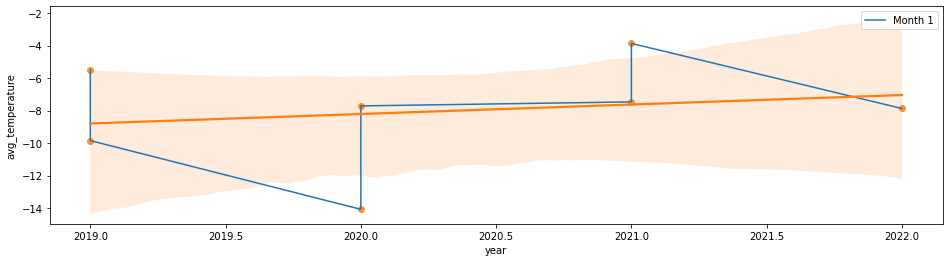

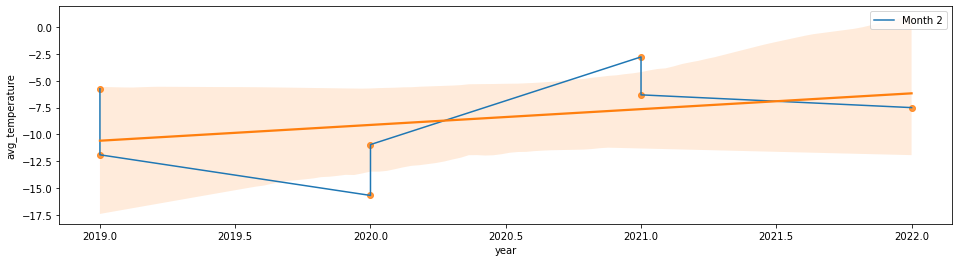

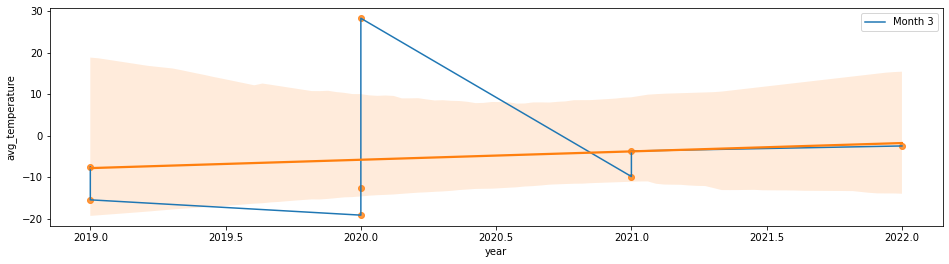

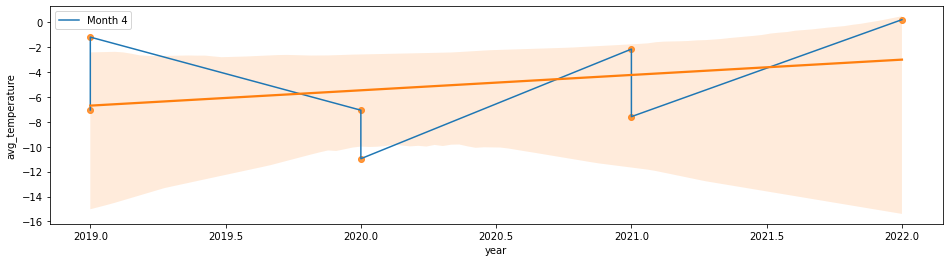

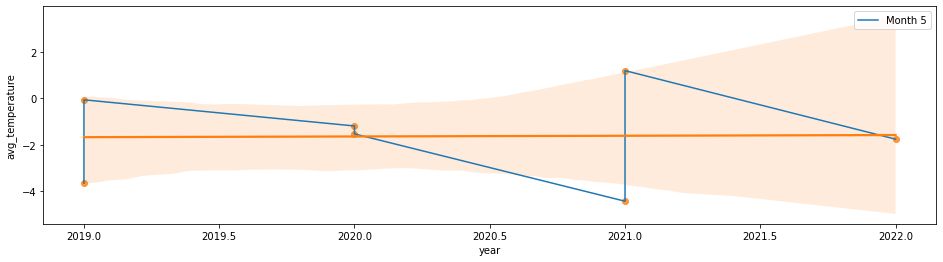

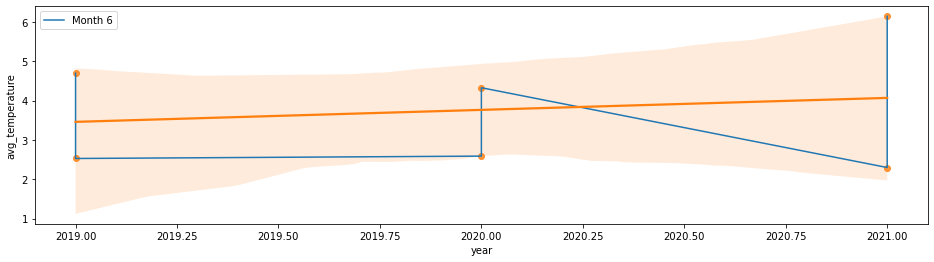

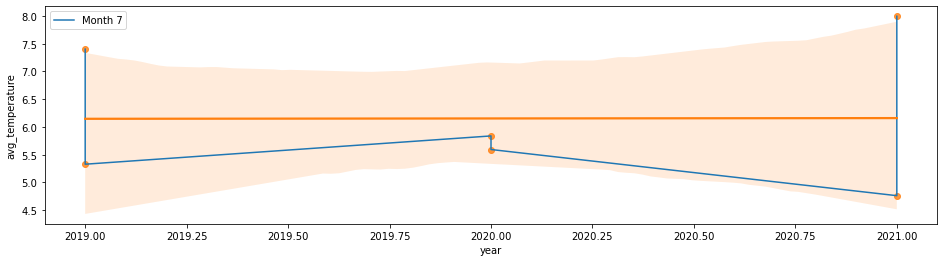

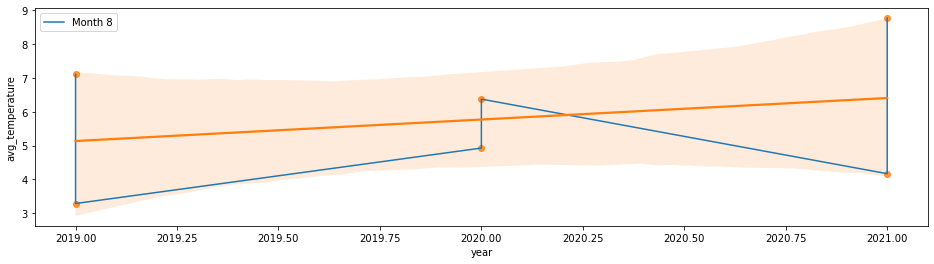

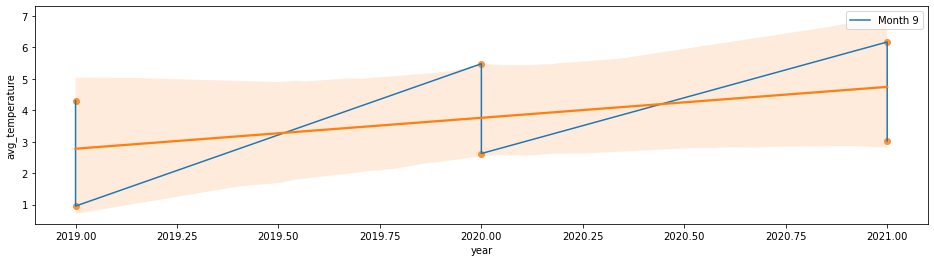

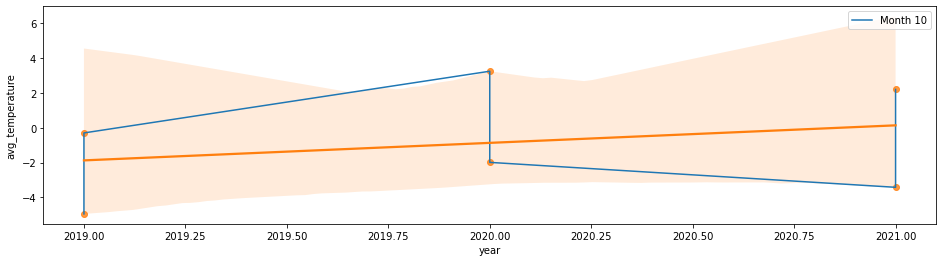

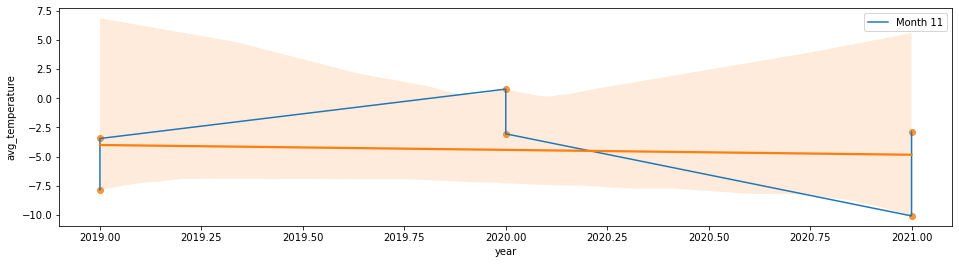

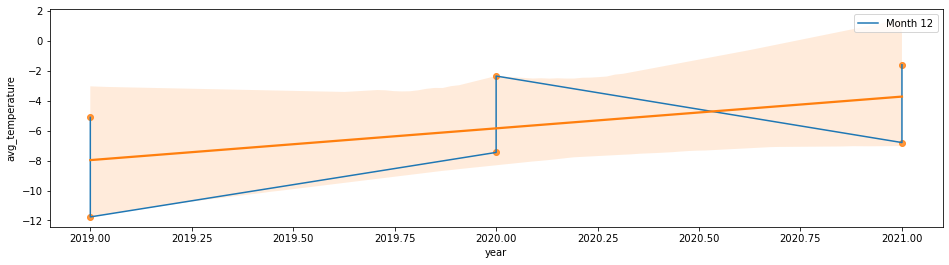

In [43]:
for m in range(1,13):
    data = df[df["month"] == m]
    plt.figure(figsize=(16,4))
    plt.plot(data["year"], data["avg_temperature"], label="Month " + str(m))
    plt.legend()
    sns.regplot(data=data, x="year", y="avg_temperature")#, aspect=3)

### Météo annuelle

In [78]:
yearly_weather = daily_country_weather \
    .withColumn("year", f.year(f.col("date"))) \
    .groupBy("year").agg(
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
        f.avg(f.col("max_wind_speed")).alias("max_wind_speed")
    )\
    .orderBy(f.col("year"))
yearly_weather.toPandas()

,year,avg_temperature,avg_wind_speed,max_wind_speed
0,2019,-2.706679,5.427928,11.891187
1,2020,-2.961883,5.710625,11.913079
2,2021,-1.056531,5.591260,10.716552
3,2022,-4.283163,6.584209,13.956183


### Météo annuelle par pays

In [80]:
yearly_countries = daily_country_weather \
    .withColumn("year", f.year(f.col("date"))) \
    .groupBy("year").agg(
        f.countDistinct(f.col("CTRY")).alias("num_countries")
    )\
    .orderBy(f.col("year"))
yearly_countries.toPandas()

,year,num_countries
0,2019,2
1,2020,2
2,2021,2
3,2022,1


### Météo En Norvège

In [81]:
country = "NO"

In [82]:
daily_country_weather = daily_country_weather.filter("CTRY = 'NO'") \
    .orderBy("date", "CTRY", "STATE") \
    .toPandas()

In [83]:
daily_country_weather

,CTRY,STATE,date,min_temperature,max_temperature,avg_temperature,min_wind_speed,max_wind_speed,avg_wind_speed
0,NO,None,2019-01-01,-19.6,5.000000,-8.139734,0.90,18.333333,9.047489
1,NO,None,2019-01-02,-19.8,6.700000,-6.459591,0.60,17.000000,6.474023
2,NO,None,2019-01-03,-15.2,6.066667,-1.942987,0.00,15.400000,6.568464
3,NO,None,2019-01-04,-11.1,8.000000,-2.074861,1.00,11.400000,4.172700
4,NO,None,2019-01-05,-13.9,5.000000,-2.635133,0.50,16.000000,5.714130
...,...,...,...,...,...,...,...,...,...
1214,NO,None,2022-04-30,-2.0,1.500000,-1.250000,2.05,9.550000,5.388889
1215,NO,None,2022-05-01,-6.0,3.000000,-2.026042,1.00,10.300000,3.788021
1216,NO,None,2022-05-02,-3.5,1.000000,-1.298611,1.25,12.400000,7.625521
1217,NO,None,2022-05-03,-4.0,1.000000,-1.678207,0.75,13.150000,6.649908


### Moyenne de temperature mensuelle

In [87]:
daily_country_weather = joined_data.groupBy("CTRY", "STATE", "date").agg(
        f.min(f.col("min_temperature")).alias("min_temperature"),
        f.max(f.col("max_temperature")).alias("max_temperature"),
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
        f.min(f.col("min_wind_speed")).alias("min_wind_speed"),
        f.max(f.col("max_wind_speed")).alias("max_wind_speed"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
    )

In [88]:
df = daily_country_weather \
    .withColumn("month", f.month(f.col("date"))) \
    .withColumn("year", f.year(f.col("date"))) \
    .orderBy(f.col("date")).toPandas()

<AxesSubplot:xlabel='year', ylabel='avg_temperature'>

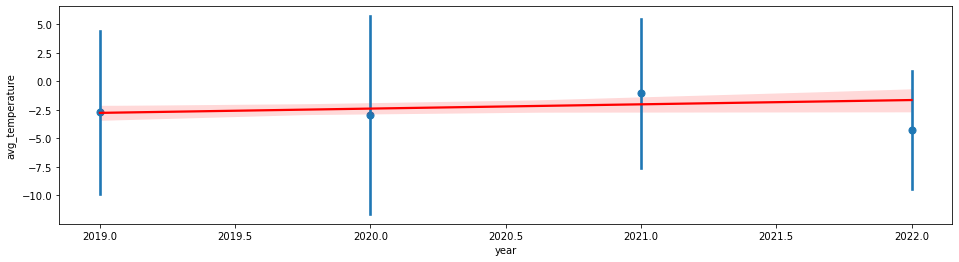

In [89]:
plt.figure(figsize=(16,4))
sns.regplot(data=df, x="year", y="avg_temperature", x_estimator=np.mean, x_ci="sd", ci=100, fit_reg=True, lowess=False, line_kws={'color':'red'})

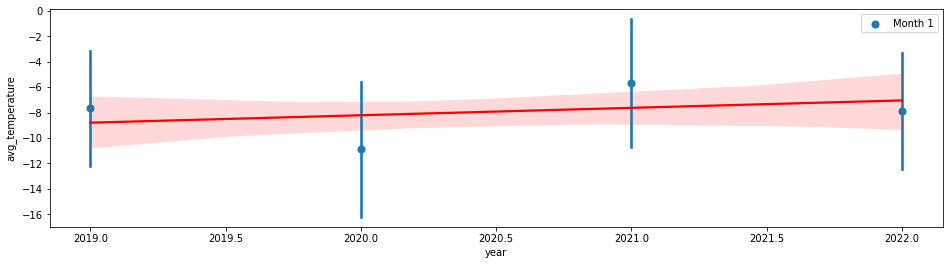

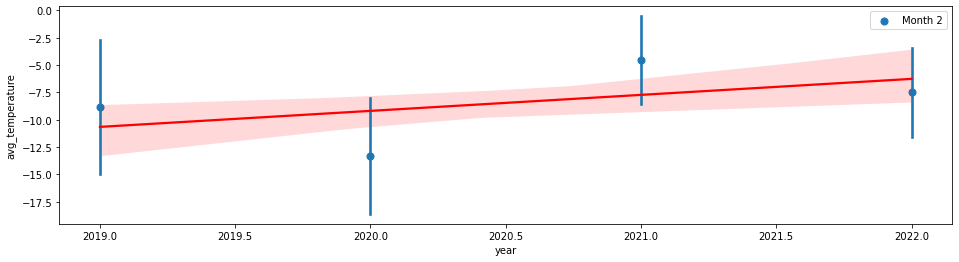

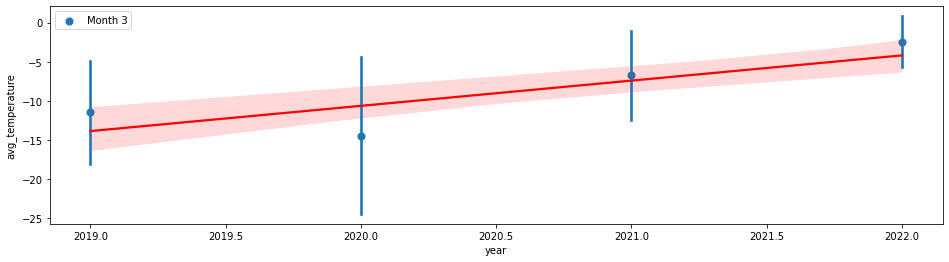

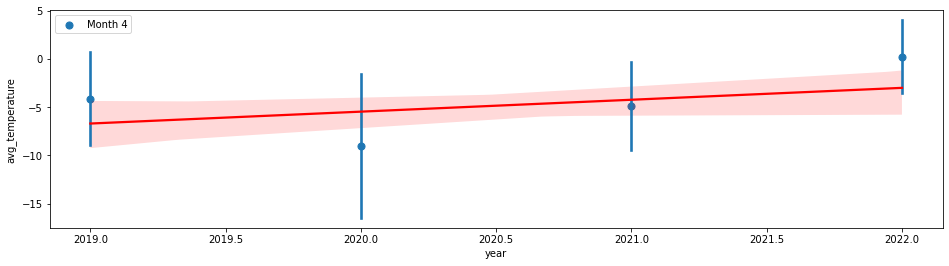

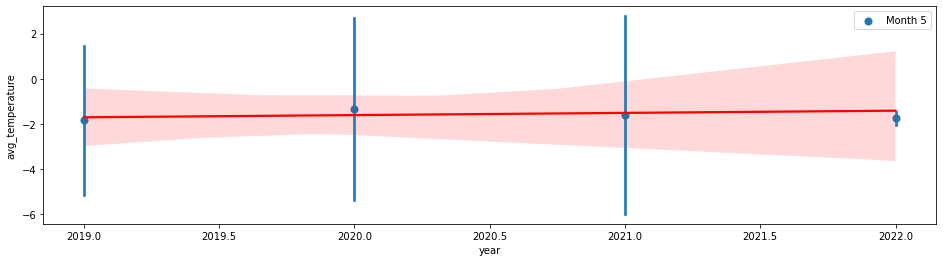

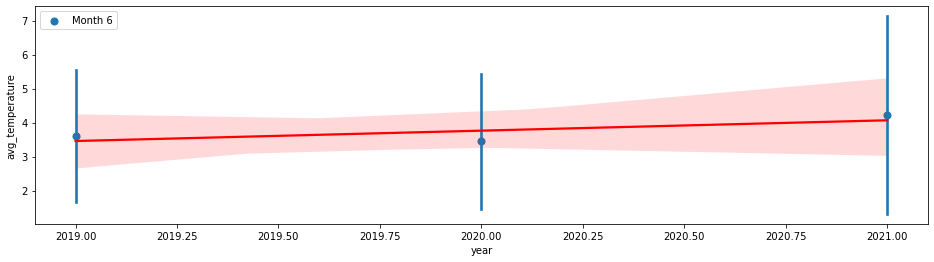

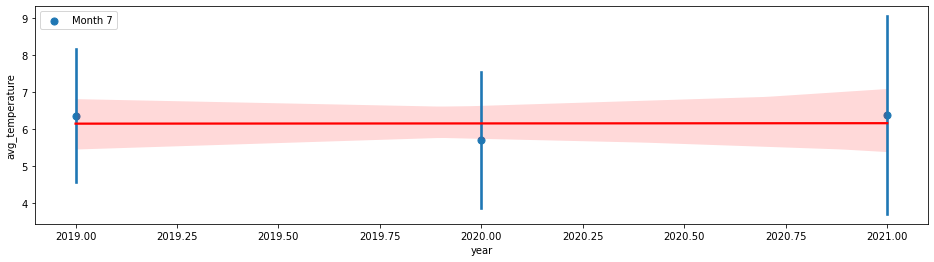

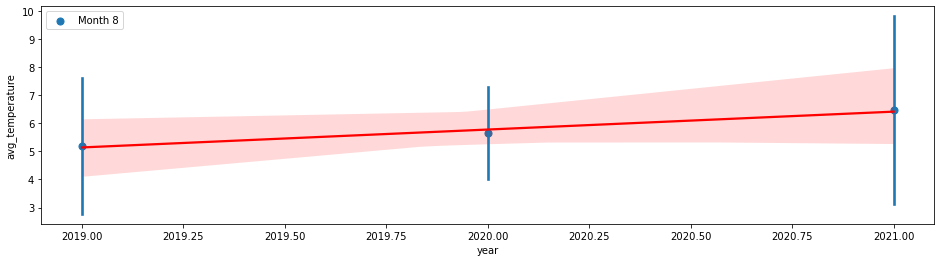

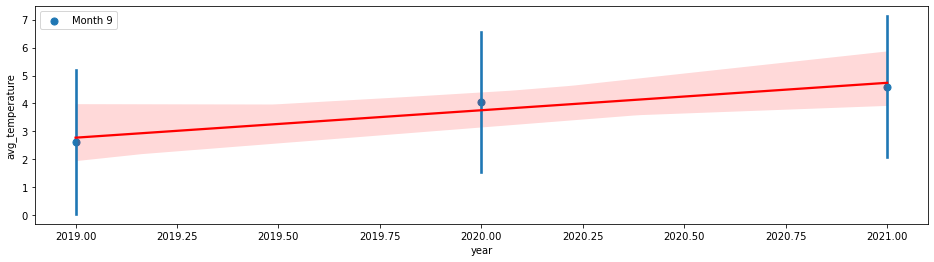

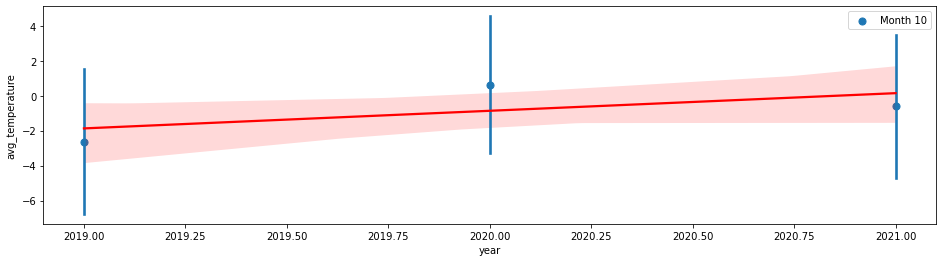

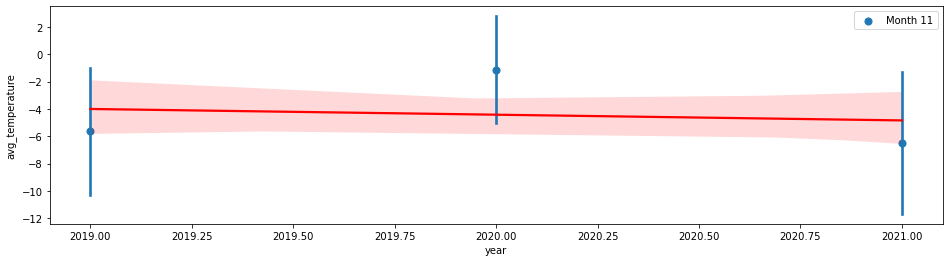

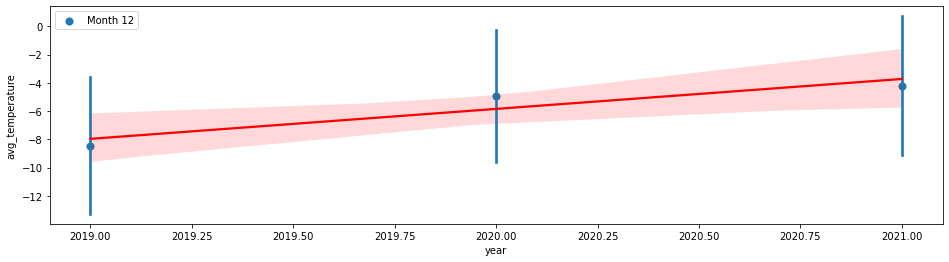

In [90]:
for m in range(1,13):
    data = df[df["month"] == m]
    plt.figure(figsize=(16,4))
    sns.regplot(data=data, x="year", y="avg_temperature", x_estimator=np.mean, x_ci="sd", ci=100, lowess=False, line_kws={'color':'red'}, label="Month " + str(m))
    plt.legend()

In [ ]:
### Enregistrement des résultats en Csv

In [57]:
# Monthly weather per station
monthly_station_weather = daily_station_weather \
    .groupBy("station_id", "STATION_NAME", "CTRY", "STATE", "LAT", "LON", "ELEVATION", f.year("date").alias("year"), f.month("date").alias("month")) \
    .agg(
        f.min(f.col("min_temperature")).alias("min_temperature"),
        f.max(f.col("max_temperature")).alias("max_temperature"),
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
       f.min(f.col("min_wind_speed")).alias("min_wind_speed"),
        f.max(f.col("max_wind_speed")).alias("max_wind_speed"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
        f.min(f.col("date")).alias("date")
    )

In [58]:
monthly_station_weather.coalesce(1).write.mode("overwrite").options(header='True', delimiter=',').csv("./resultsnew")

In [55]:
monthly_station_weather

station_id,STATION_NAME,CTRY,STATE,LAT,LON,ELEVATION,year,month,min_temperature,max_temperature,avg_temperature,min_wind_speed,max_wind_speed,avg_wind_speed,date
01010099999,ANDOYA,NO,null,+69.293,+016.144,+0013.1,2019,3,-11.066666666666668,5.033333333333333,-1.5094623655913981,0.5,20.85,7.490762602216154,2019-03-01
01083099999,BERLEVAG,NO,null,+70.867,+029.033,+0013.0,2022,4,-8.0,8.0,0.43075040427981603,0.5,17.75,7.797215114338275,2022-04-01
01007099999,NY-ALESUND,SV,null,+78.917,+011.933,+0007.7,2020,5,-9.7,7.8,-0.2483848779853647,0.0,16.4,4.184923989208659,2020-05-01
01008099999,LONGYEAR,SV,null,+78.246,+015.466,+0026.8,2021,6,-1.0,9.5,3.274385195118889,0.0,14.4,5.060597394755006,2021-06-01
01002099999,VERLEGENHUKEN,NO,null,+80.050,+016.250,+0008.0,2020,9,-1.0,5.2,1.773263888888889,2.6,12.5,6.507291666666666,2020-09-01
01001099999,JAN MAYEN(NOR-NAVY),NO,null,+70.933,-008.667,+0009.0,2021,6,-0.5,10.1,3.530737755400799,0.3,22.2,5.357937997992346,2021-06-01
01007099999,NY-ALESUND,SV,null,+78.917,+011.933,+0007.7,2019,8,0.0,9.8,4.711436418887332,0.4,19.0,3.358279118686269,2019-08-01
01006099999,EDGEOYA,NO,null,+78.250,+022.817,+0014.0,2021,10,-5.0,1.5,-1.862962962962963,0.0,15.6,7.180555555555555,2021-10-02
01001099999,JAN MAYEN(NOR-NAVY),NO,null,+70.933,-008.667,+0009.0,2021,1,-9.5,3.0,-1.6759615012012707,0.2,22.0,8.404402471924211,2021-01-01
01003099999,HORNSUND,NO,null,+77.000,+015.500,+0012.0,2019,6,-1.3,10.2,3.5218357487922707,0.6,15.0,4.190694444444444,2019-06-01


In [90]:
res = monthly_station_weather.orderBy("station_id","month")

In [91]:
res.write.mode("overwrite").options(header='True', delimiter=',').csv("./output")

In [ ]:
firstCsv = daily_station_weather.groupBy("station_id", "STATION_NAME", "CTRY", "STATE", "LAT", "LON", "ELEVATION", "date", "min_temperature", "max_temperature", "avg_temperature", "min_wind_speed", "max_wind_speed", "avg_wind_speed") \
    .agg(f.max("date"))

In [ ]:
firstCsv.coalesce(1).write.mode("overwrite").options(header='True', delimiter=',').csv(results_basedir)

In [56]:
monthly_country_weather.orderBy("date").coalesce(1).write.mode("overwrite").options(header='True', delimiter=',').csv("./results")